In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
DATA_PATH = "/content/drive/MyDrive/Project3_EcommerceAnalysis/data/processed/ecommerce_cleaned.csv"

df = pd.read_csv(DATA_PATH)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [3]:
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)


In [4]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,
    "InvoiceNo": "nunique",
    "Revenue": "sum"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12347.0,11,1,711.79
1,12348.0,1,1,892.80
2,12370.0,1,2,1868.02
3,12386.0,10,1,258.90
4,12395.0,1,2,679.92


In [5]:
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])


In [8]:
rfm["R_Score"] = rfm["R_Score"].astype(int)
rfm["F_Score"] = rfm["F_Score"].astype(int)
rfm["M_Score"] = rfm["M_Score"].astype(int)


In [9]:
def segment_customer(row):
    if row["R_Score"] == 4 and row["F_Score"] == 4:
        return "Champions"
    elif row["F_Score"] >= 3:
        return "Loyal Customers"
    elif row["R_Score"] >= 3:
        return "Potential Loyalists"
    elif row["R_Score"] == 1:
        return "At Risk"
    else:
        return "Others"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)


In [10]:
rfm["Segment"].value_counts()


,count
Segment,
Loyal Customers,304
Potential Loyalists,195
At Risk,127
Champions,114
Others,97


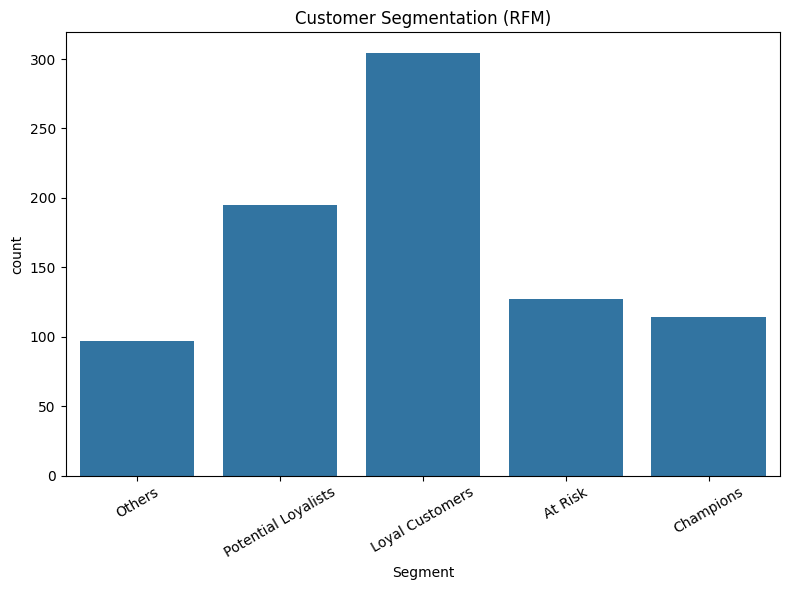

In [19]:
plt.figure(figsize=(8,6))
sns.countplot(data=rfm, x="Segment")
plt.xticks(rotation=30)
plt.title("Customer Segmentation (RFM)")
plt.tight_layout()
plt.savefig(
    "/content/drive/MyDrive/Project3_EcommerceAnalysis/dashboards/customer_segmentation.png",
    dpi=300
)

plt.show()


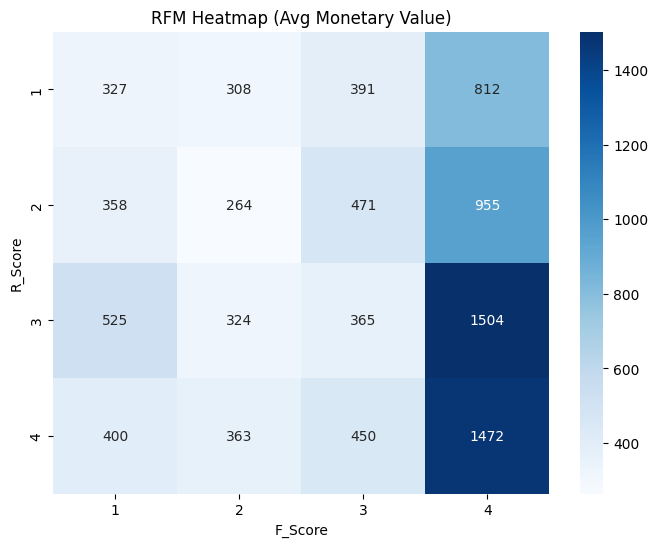

In [20]:
pivot = rfm.pivot_table(
    index="R_Score",
    columns="F_Score",
    values="Monetary",
    aggfunc="mean"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Blues")
plt.title("RFM Heatmap (Avg Monetary Value)")
plt.savefig(
    "/content/drive/MyDrive/Project3_EcommerceAnalysis/dashboards/avg_monetary_value.png",
    dpi=300
)
plt.show()
